In [2]:
%cd "/home/qite/my/pytorch-pose"
%matplotlib inline
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import cv2
import numpy as np
import torch
from ruamel.yaml import YAML
import matplotlib.pyplot as plt
import pose.utils.config as config
import experiments.locate
reload(experiments.locate)

from pose.utils.evaluation import PR_locate

/home/qite/my/pytorch-pose


In [3]:
exp_name = "locate"
exp_num = 6
resume_checkpoint = 40

config.exp_name = exp_name
with open("experiments/config.yaml", "r") as f:
    config.__dict__.update(YAML(typ="safe").load(f)["default"].items())

with open("checkpoint/%s/%d/hparams.yaml" % (exp_name, exp_num), "r") as f:
    hparams = YAML(typ="safe").load(f)

exp = experiments.locate.Experiment(hparams)
checkpoint = torch.load(os.path.join("checkpoint/%s/%d/checkpoint_%d.pth.tar" % (exp_name, exp_num, resume_checkpoint)))
exp.hparams["start_epoch"] = checkpoint["epoch"]
exp.model.load_state_dict(checkpoint['state_dict'])
exp.criterion.load_state_dict(checkpoint['criterion'])
exp.optimizer.load_state_dict(checkpoint['optimizer'])

BATCH_SIZE = 32

val_loader = torch.utils.data.DataLoader(
    exp.val_dataset,
    collate_fn=exp.test_collate_fn if 'test_collate_fn' in exp.__dict__ else default_collate,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False,
    pin_memory=True)

loading annotations into memory...
Done (t=5.29s)
creating index...
index created!
    Mean: 118.1302, 112.9985, 105.2188
    Std:  63.8414, 61.6500, 61.9024


In [97]:
INP_RES = 256
LABEL_SIZE = 3
def draw_label(img_bgr, labels, label_type):
    for label in labels:
        if (label[:2] >= 0).all() and (label[:2] < INP_RES).all():
            if label_type == 'CT':
                img_bgr = cv2.circle(img_bgr, (int(label[0]), int(label[1])), LABEL_SIZE+2, (255, 0, 0), thickness=-1)
            elif label_type == 'TP':
                img_bgr = cv2.circle(img_bgr, (int(label[0]), int(label[1])), LABEL_SIZE, (255, 255, 255), thickness=-1)
            elif label_type == 'PT':
                img_bgr = cv2.circle(img_bgr, (int(label[0]), int(label[1])), LABEL_SIZE, (0, 0, 255), thickness=-1)
            else:
                raise RuntimeError()
    return img_bgr

def process(batch, train, detail=None):
    locate_index = exp.hparams["model"]["part_locate"]

    model_loc = exp.model
    criterion_mse = exp.criterion

    img, locate_map_gt, mask, extra = batch
    volatile = not train

    img_var = torch.autograd.Variable(img.cuda(async=True), volatile=volatile)
    locate_map_gt_var = torch.autograd.Variable(locate_map_gt.cuda(async=True), volatile=volatile)
    mask_var = torch.autograd.Variable(mask.cuda(async=True), volatile=volatile)
    keypoint_gt = extra["keypoints_tf_inp"]

    # locate_gt: #batch x [#batch_i_valid_person x 2]
    locate_gt = []
    num_gt = 0
    for kpgt in keypoint_gt:
        index_labeled = torch.nonzero(kpgt[:, locate_index, 2] > 0)
        if len(index_labeled) > 0:
            locate_bi = kpgt[index_labeled[:, 0]][:, locate_index, :2]
            index_inside = torch.nonzero(((locate_bi >= 0) & (locate_bi < INP_RES)).sum(dim=-1) == 2)
            if len(index_inside) > 0:
                locate_gt.append(locate_bi[index_inside[:, 0]])
                num_gt += len(index_inside)
            else:
                locate_gt.append(torch.FloatTensor(0))
        else:
            locate_gt.append(torch.FloatTensor(0))
    
    # Locate nose
    locate_map_pred_var, _ = model_loc(img_var)
    
    locate_map_pred_np = locate_map_pred_var.data.cpu().numpy()
    
    draw_img_bgr = ((img.numpy()[:, ::-1].transpose((0, 2, 3, 1)) + exp.train_dataset.mean[::-1]) * 255).clip(0, 255).astype(np.uint8)
    for i in range(len(draw_img_bgr)):
        pred_map_img = cv2.applyColorMap(
                cv2.resize(
                    (locate_map_pred_np[i].transpose(1, 2, 0) * 255).clip(0, 255).astype(np.uint8),
                    (INP_RES, INP_RES)),
                cv2.COLORMAP_HOT)
        draw_img_bgr[i] = cv2.addWeighted(draw_img_bgr[i], 1, pred_map_img, 0.5, 0)
    
    for i in range(len(locate_gt)):
        draw_img_bgr[i] = draw_label(draw_img_bgr[i], locate_gt[i], "CT")

    # Locating Loss
    loss = criterion_mse(locate_map_pred_var, locate_map_gt_var, mask_var)

    # Parse locate_map_pred_var, convert it into ground truth keypoints format
    # locate_pred: #batch x [#batch_i_person, 2]
    locate_pred = exp.posemap_parser.parse(locate_map_pred_var, mask_var, factor=4)

    for i in range(len(locate_pred)):
        draw_img_bgr[i] = draw_label(draw_img_bgr[i], locate_pred[i], "PT")
    
    # Match locating point with person in ground truth keypoints
    # match_*: #match x #match_i_*
    match_pred, match_gt = match_locate(locate_pred, locate_gt, threshold_abandon=float(INP_RES)/20)
    
    for i in range(len(match_pred)):
        if len(match_pred[i]) > 0:
            draw_img_bgr[i] = draw_label(draw_img_bgr[i], locate_pred[i][match_pred[i]], "TP")
            for mpred, mgt in zip(match_pred[i], match_gt[i]):
                draw_img_bgr[i] = cv2.line(draw_img_bgr[i], tuple(locate_pred[i][mpred].int().tolist()), tuple(locate_gt[i][mgt].int().tolist()), (255, 255, 255))
        
    draw_img = draw_img_bgr[:, :, :, ::-1]
    
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(40, 20), gridspec_kw={"wspace": 0, "hspace": 0, "left": 0, "right": 1, "top": 1, "bottom": 0})
    for i in range(len(draw_img)):
        axes.flat[i].axis("off")
        axes.flat[i].imshow(draw_img[i])
    
    plt.show()

    precision, recall = PR_locate(locate_pred, locate_gt, match_pred, match_gt, norm=float(INP_RES)/10)

    print(len(draw_img))
    print("precision: %f, recall: %f" % (precision, recall))


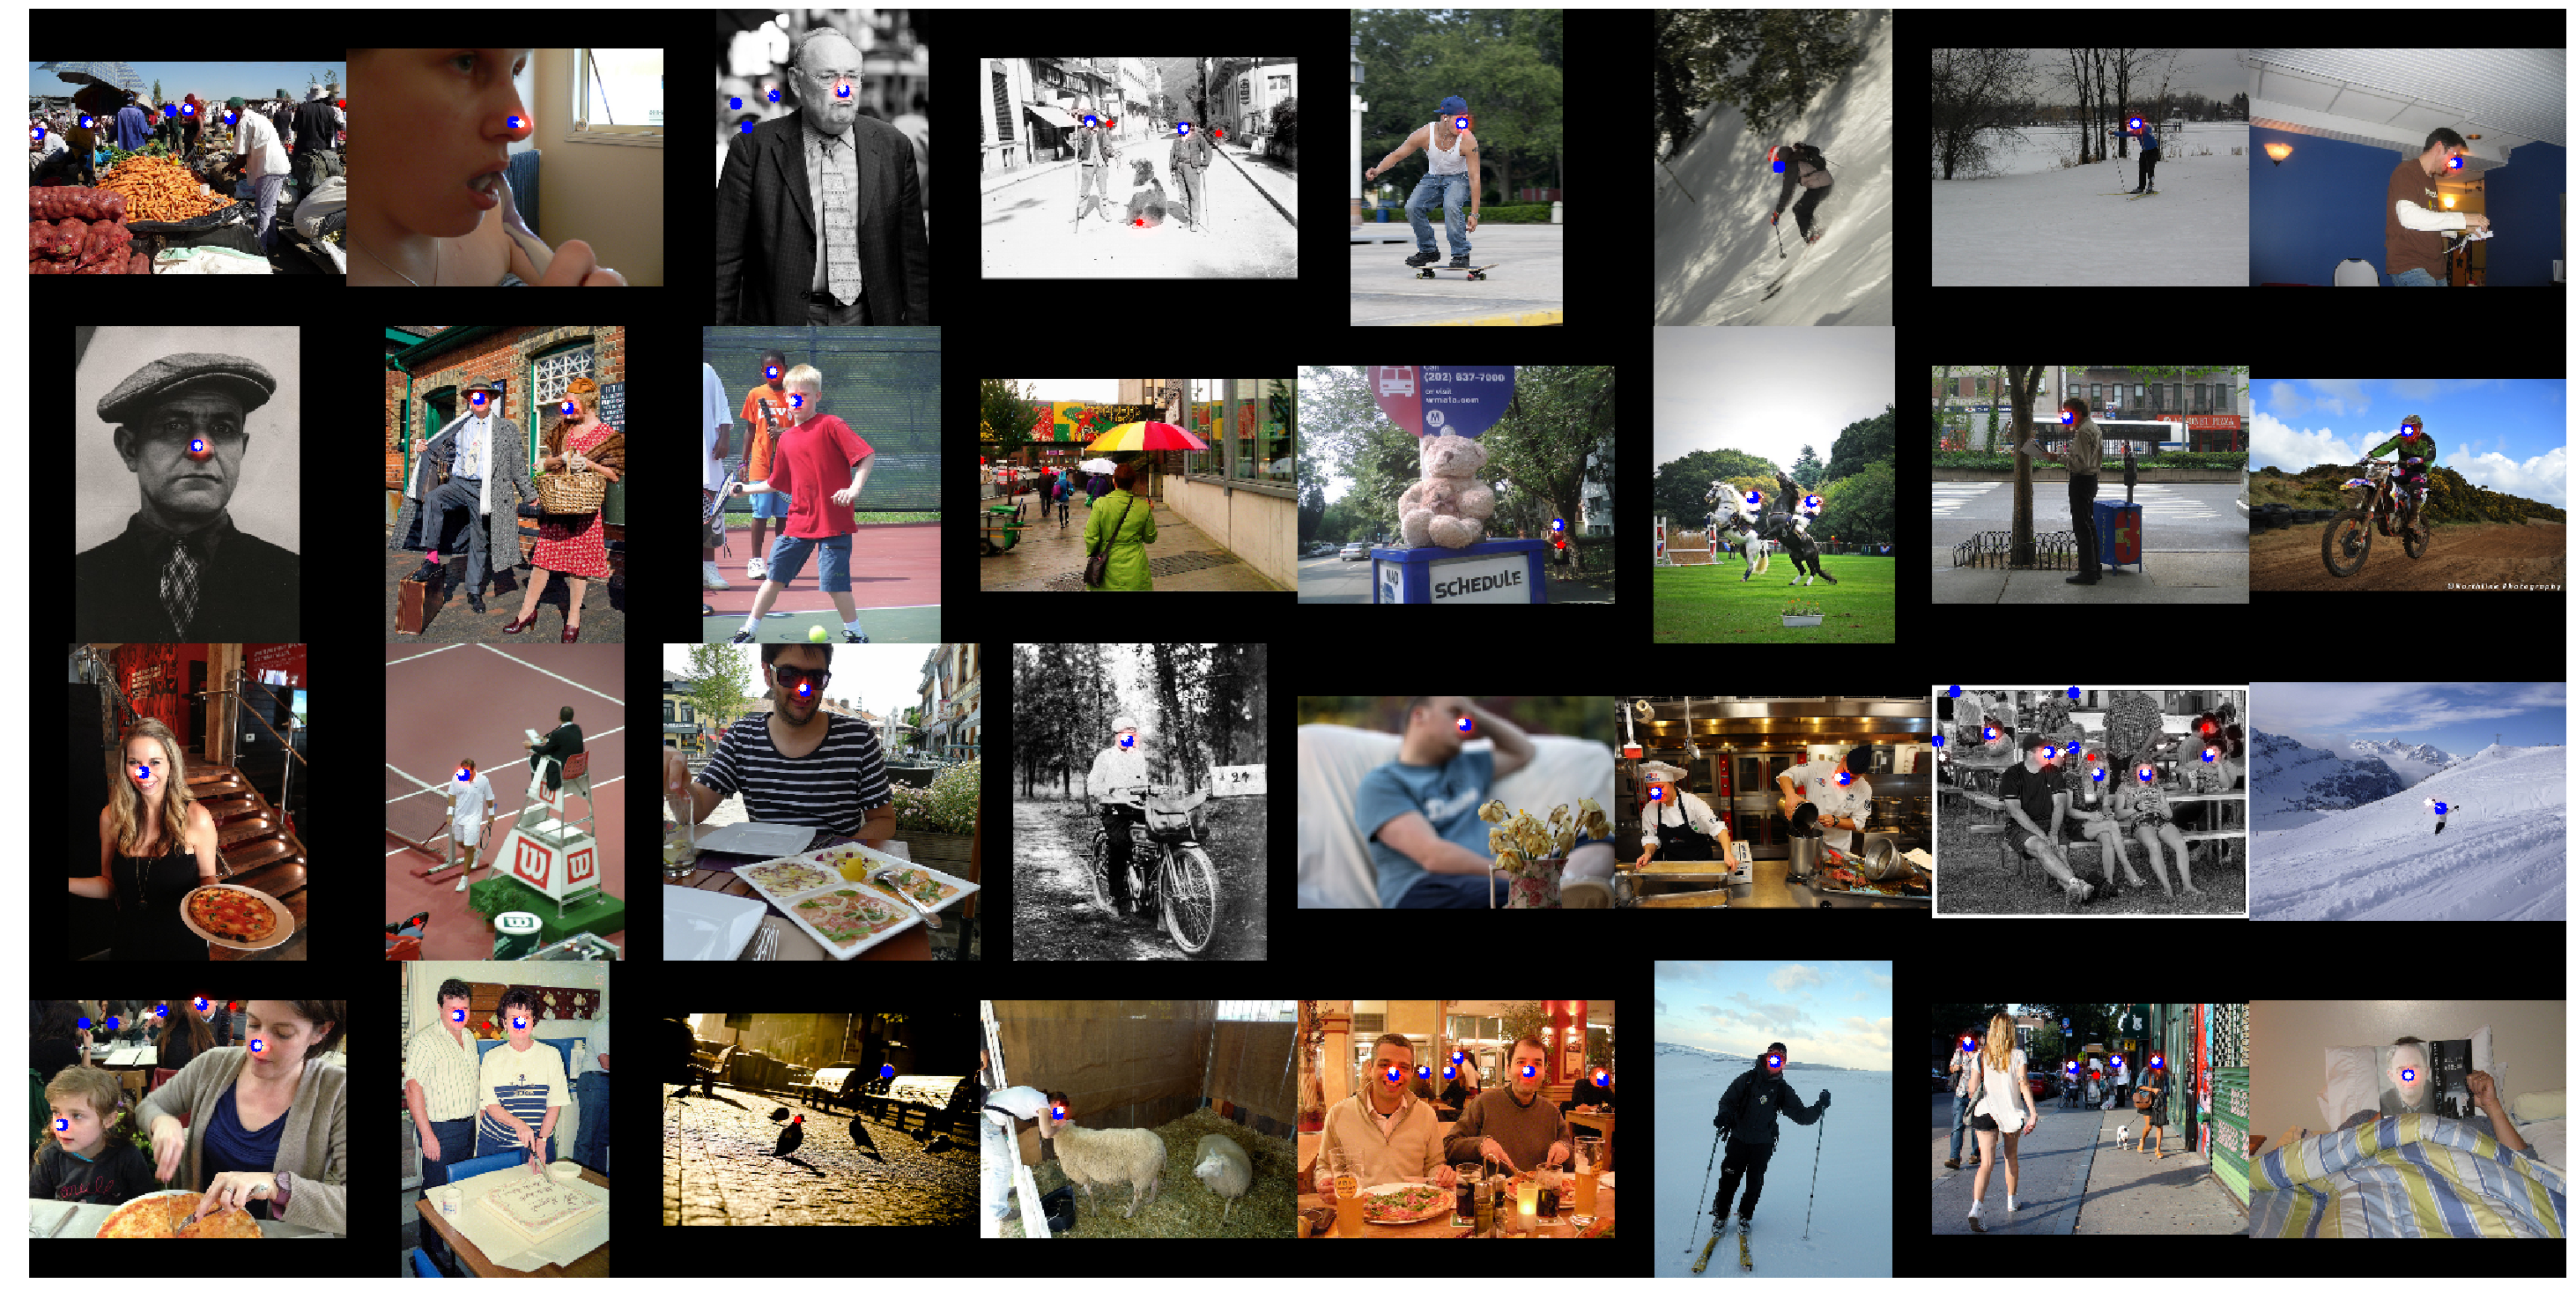

32
precision: 0.800000, recall: 0.861538
Continue?(y|n)n


In [98]:
for i, batch in enumerate(val_loader):
    detail = {
        "epoch": 0,
        "iter": i,
        "iter_len": len(val_loader),
        "summary": False
    }
    process(batch, False, detail=detail)
    ans = input("Continue?(y|n)")
    if ans == "y":
        continue
    else:
        break

In [12]:
coco = exp.coco
train_indices = exp.train_dataset.train
part_counter = np.zeros(17, dtype=np.int64)
locate_counter = 0
all_counter = 0
for img_index in train_indices:
    ann_ids = coco.getAnnIds(imgIds=img_index)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        if ann["num_keypoints"] > 0:
            kp = ann["keypoints"]
            assert len(kp) == 17 * 3
            kp = np.array(kp).reshape((-1, 3))
            part_counter += (kp[:, 2] > 0).astype(np.int)
            if (kp[5, 2] > 0 and kp[6, 2] > 0) or \
                (kp[0, 2] > 0) or \
                (kp[1, 2] > 0 and kp[2, 2] > 0) or \
                (kp[3, 2] > 0 and kp[4, 2] > 0) or \
                (kp[7, 2] > 0 and kp[8, 2] > 0) or \
                (kp):
                locate_counter += 1
            all_counter += 1
print(part_counter.astype(np.float32) / all_counter)
print(float(locate_counter) / all_counter)

[0.67707886 0.58849883 0.59263505 0.51255672 0.51995033 0.8728089
 0.87461432 0.69048097 0.70206811 0.63086402 0.64796294 0.75769212
 0.75960262 0.57933801 0.58032192 0.48686058 0.48670774]
0.942245784974


In [15]:
len(train_indices)

39435